Map Hardiness zones to cultivars

Reference:
-  https://en.wikipedia.org/wiki/Hardiness_zone
- https://planthardiness.ars.usda.gov/

In [165]:
import geopandas as gpd
import pandas as pd
import numpy as np

import os
import sys

import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib import cm 
from IPython.display import HTML

rel_path = "../src"
directory_path = os.path.abspath(os.path.join(os.getcwd(), rel_path))
sys.path.append(directory_path)

from hardiness import temp_min, output_hardiness, get_hardiness

In [2]:
# Apple Description
apple_cultivars = pd.read_csv('../data/processed/starkbros_apples.csv')

# sample region
#df_path = '../data/processed/df_easternmountain_weather.parquet.gzip'
#df = pd.read_parquet(df_path)
#zones = get_hardiness(df).to_frame()
#zones.rename(columns ={'fahrenheit':'zone'}, inplace= True)

# results from regression:
df_path = '../data/processed/df_easternmountain_results.parquet.gzip'
zones = pd.read_parquet(df_path)
zones['time']=pd.to_datetime(zones['time'])
zones = zones.set_index(['time','lat','lon'])
# zones.

# read states
states = gpd.read_file('../data/external/cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
states = states.to_crs("EPSG:4326") 
east = states[states['STUSPS'].isin(['VA','NC','WV','MD','PA'])]

# read ground truth 
# ground_truth = pd.read_csv('../data/external/test_era5/oiko_easternmountain.csv')
# ground_truth['time'] = pd.to_datetime(ground_truth['time'])

# orchards
orchards_shape_file_path = "../data/processed/gdf_easternmountain_polygons/gdf_easternmountain_polygons.shp"
east_orchards_gdf = gpd.read_file(orchards_shape_file_path)

In [3]:
# Pre-Processing:
apple_cultivars['Min_zone'] = apple_cultivars['Zone Range'].apply(lambda x: int(x[0]))
apple_cultivars['Max_zone'] = apple_cultivars['Zone Range'].apply(lambda x: int(x[-1]))
apple_cultivars.rename(columns = {'Unnamed: 0':'Apple'}, inplace=True)

apple_cultivars.set_index('Apple', inplace= True)

In [4]:
# Add Encoding
for apple in apple_cultivars.index:
    zones[apple] = False

In [5]:
# Assign Cultivars 
# takes about 10 minutes to complete
zones = zones.sort_index()
for index, row in zones.iterrows():
    for apple in apple_cultivars.index:
        if row.zone >= apple_cultivars.loc[apple].Min_zone and row.zone <= apple_cultivars.loc[apple].Max_zone:
            zones.loc[index, apple] = True
            #print(f'for {apple} on {index} with {row.USDA_zone}, it can be grown with {apple_cultivars.loc[apple].Min_zone}-{apple_cultivars.loc[apple].Max_zone}')

In [6]:
zones.shape

(4023, 78)

In [7]:
# convert to Geopandas
lat = [i[1] for i in zones.index]
lon = [i[2] for i in zones.index]
# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
gdf = gpd.GeoDataFrame(zones, geometry= gpd.points_from_xy(lon,lat), crs="EPSG:4326")
gdf.to_csv('../data/processed/weather_usda_zones.csv')

In [8]:
gdf.head()

temp  zone  ambrosia-apple  \
time       lat   lon                                      
2014-12-31 35.25 -83.25 -1.424789   6.5            True   
                 -83.00 -1.701387   6.5            True   
                 -82.75  2.129008   7.0            True   
                 -82.50  5.497417   7.0            True   
                 -82.25  8.299410   7.5            True   

                         apple-babe-genetic-dwarf-apple  baldwin-apple  \
time       lat   lon                                                     
2014-12-31 35.25 -83.25                            True           True   
                 -83.00                            True           True   
                 -82.75                            True           True   
                 -82.50                            True           True   
                 -82.25                            True           True   

                         ben-davis-apple  braeburn-apple  buckeye-gala-apple  \
time       lat   lon                                                           
2014-12-31 35.25 -83.25             True            True                True   
                 -83.00             True            True                True   
                 -82.75             True            True                True   
                 -82.50             True            True                True   
                 -82.25            False            True                True   

                         candycrisp-apple  chenango-strawberry-apple  ...  \
time       lat   lon                                                  ...   
2014-12-31 35.25 -83.25              True                       True  ...   
                 -83.00              True                       True  ...   
                 -82.75              True                       True  ...   
                 -82.50              True                       True  ...   
                 -82.25             False                       True  ...   

                         wealthy-apple  whitney-crabapple  \
time       lat   lon                                        
2014-12-31 35.25 -83.25           True               True   
                 -83.00           True               True   
                 -82.75           True               True   
                 -82.50           True               True   
                 -82.25           True               True   

                         wiltons-red-jonaprince-apple  winecrisp-apple  \
time       lat   lon                                                     
2014-12-31 35.25 -83.25                          True             True   
                 -83.00                          True             True   
                 -82.75                          True             True   
                 -82.50                          True             True   
                 -82.25                          True             True   

                         wolf-river-apple  yellow-transparent-apple  \
time       lat   lon                                                  
2014-12-31 35.25 -83.25              True                      True   
                 -83.00              True                      True   
                 -82.75              True                      True   
                 -82.50              True                      True   
                 -82.25              True                      True   

                         york-imperial-apple  zestar-apple  \
time       lat   lon                                         
2014-12-31 35.25 -83.25                 True          True   
                 -83.00                 True          True   
                 -82.75                 True          True   
                 -82.50                 True          True   
                 -82.25                 True          True   

                         starkspur-winter-banana-antique-apple  \
time       lat   lon                             

In [9]:
gdf_2014 = gdf.loc['2014-12-31']
overlayed = gpd.overlay(east_orchards_gdf, gdf_2014, how='intersection',keep_geom_type=False)

Text(0.5, 1.0, '2014-12-31 USDA Map')

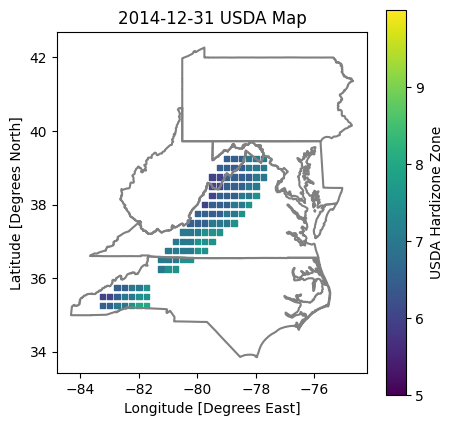

In [10]:
us_boundary_map = east.boundary.plot(figsize=(5, 5), color="Gray")
overlayed.plot(ax = us_boundary_map,column = 'zone', marker = 's',markersize=15, legend = True,
            legend_kwds={"label": "USDA Hardizone Zone", "orientation": "vertical", 'ticks':[i for i in range(5,10)]},vmin = 5,vmax = 10)

plt.xlabel('Longitude [Degrees East]')
plt.ylabel('Latitude [Degrees North]')
plt.title('2014-12-31 USDA Map')

Time Horizon

In [11]:
dates = list(set([i[0] for i in zones.index]))

# https://stackoverflow.com/questions/42462935/how-to-sort-by-timestamps-in-pandas
dates = pd.to_datetime(dates, format="%Y%m%d:%H:%M:%S.%f").sort_values().to_list()

In [117]:
fig, [ax,cax] = plt.subplots(1, 2, figsize = (10,5), gridspec_kw={"width_ratios":[50,1]})

cmap = cm.ScalarMappable(Normalize(5, 10))#, colors)

#Create the colorbar with colormap
plt.colorbar(mappable = cmap, cax = cax)
cax.set_title('USDA Hardiness Zone')

#We'll pass this function to FuncAnimation to create the animation
def plot_frame(ts):

    gdf2 = gdf.loc[dates[ts]]
    
    ax.set_title('Eastern US USDA Hardiness Zones: {}'.format(dates[ts]))
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    
    east.plot(color = 'grey', ax = ax) 
    overlayed = gpd.overlay(east_orchards_gdf, gdf2, how='intersection',keep_geom_type=False)
    overlayed.plot(ax =ax,column = 'zone', marker = 's',markersize=15, 
            legend_kwds={"label": "USDA Hardizone Zone", "orientation": "vertical", 'ticks':[i for i in range(5,10)]}
            ,vmin = 5,vmax = 10)
            
    plt.close()

# To solve for the interval argument in FuncAnimation
# TBD.

anim = FuncAnimation(fig, plot_frame,  
                    frames = range(0,len(dates)),
                    #frames = range(0,2),
                    interval = 200)


HTML(anim.to_jshtml())

In [118]:
# save to disk
anim.save('../assets/weather_usda.gif', writer='pillow')

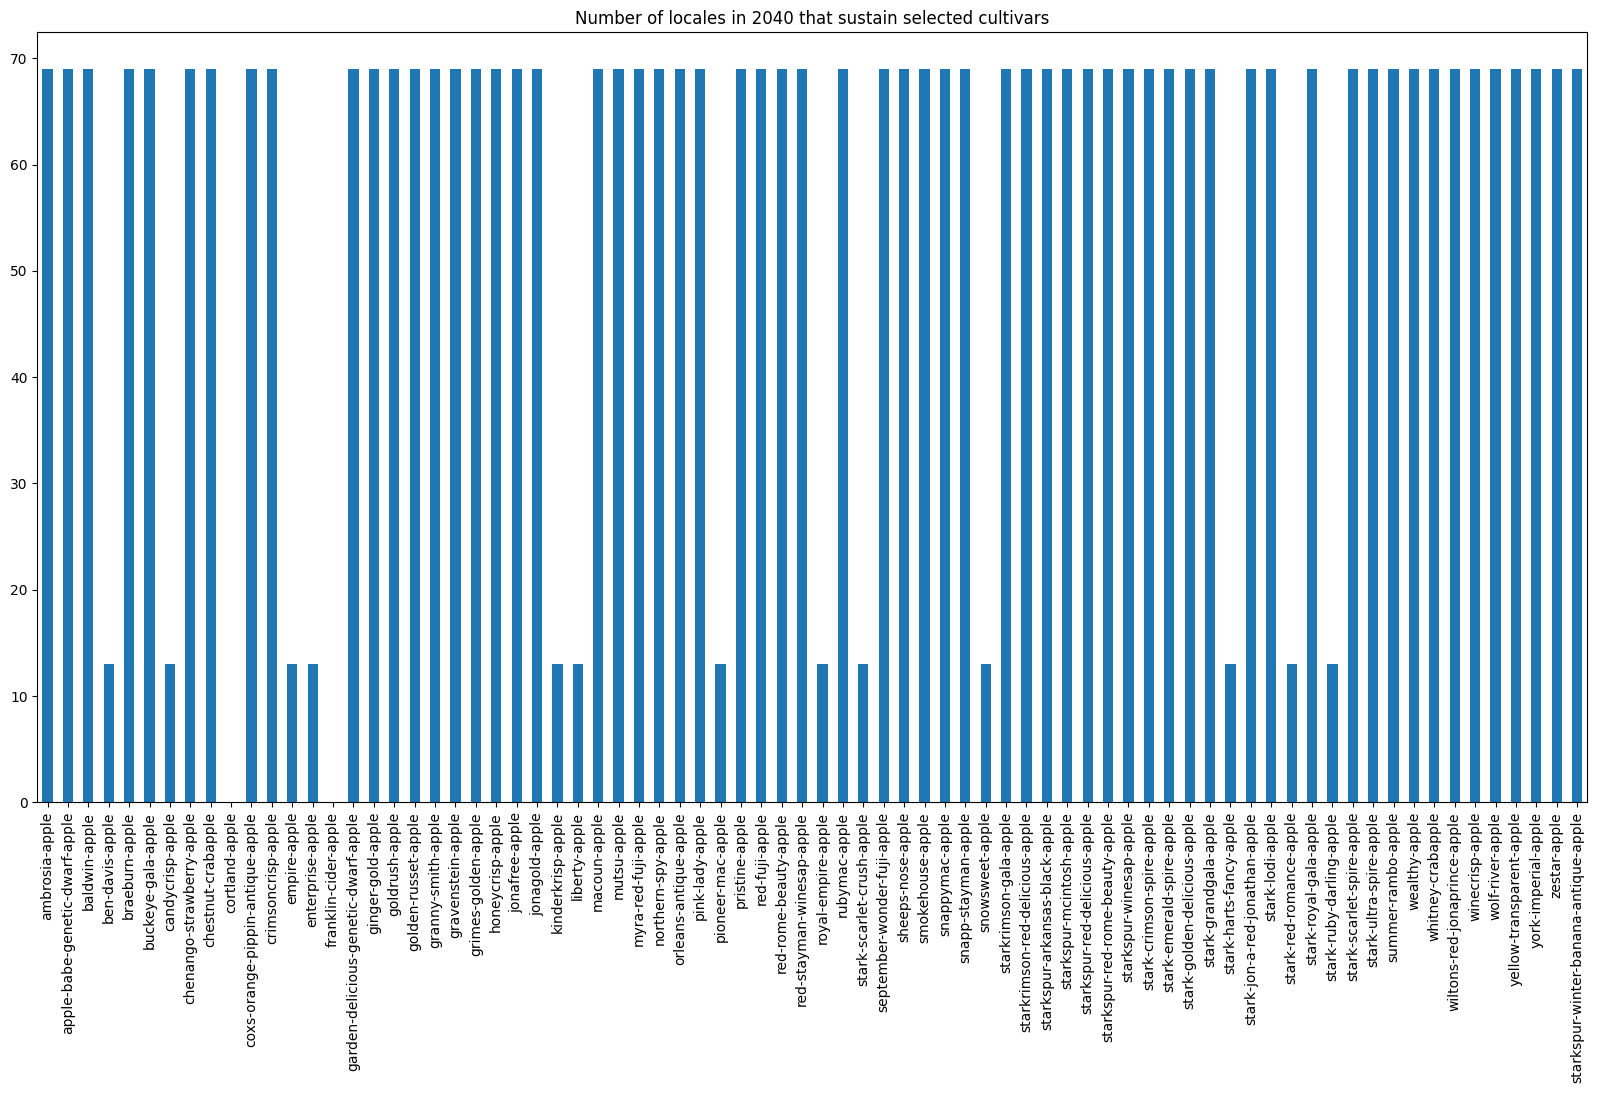

In [135]:
fig = plt.figure(figsize=[20,10])
gdf.loc['2040-12-31'][apple_cultivars.index].sum(axis=0).plot.bar()
plt.title('Number of locales in 2040 that sustain selected cultivars')
plt.show()

In [60]:
print(apple_cultivars['Max_zone'].unique())
apple_cultivars[apple_cultivars['Max_zone']<8].index

[8 7 9 6]


Index(['ben-davis-apple', 'candycrisp-apple', 'cortland-apple', 'empire-apple',
       'enterprise-apple', 'franklin-cider-apple', 'kinderkrisp-apple',
       'liberty-apple', 'pioneer-mac-apple', 'royal-empire-apple',
       'stark-scarlet-crush-apple', 'snowsweet-apple',
       'stark-harts-fancy-apple', 'stark-red-romance-apple',
       'stark-ruby-darling-apple'],
      dtype='object', name='Apple')

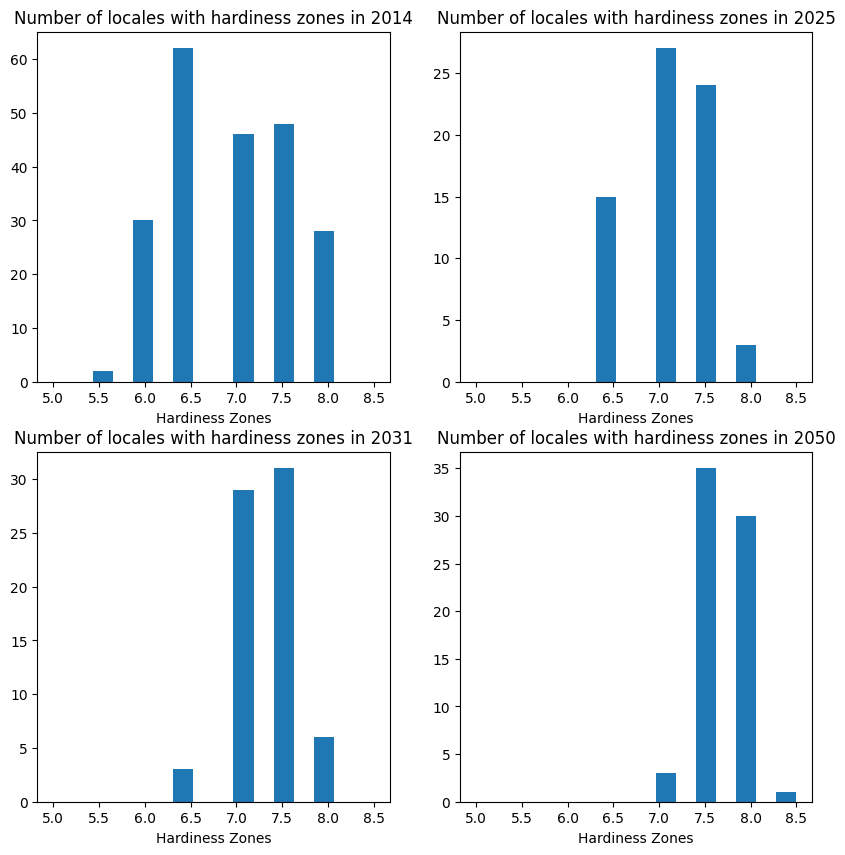

In [184]:
fig2, axes = plt.subplots(2,2,figsize=[10,10])
# def plot_zone_hist(ts):
#     gdf.loc[dates[ts]].zone.hist(ax=ax2,figure=fig2)
#     plt.close()

# hist_anim = FuncAnimation(fig2, plot_zone_hist,  
#                     frames = range(0,len(dates)),
#                     #frames = range(0,2),
#                     interval = 200)
years = ['2014','2025','2031','2050']
i=0
for row in axes:
    for ax in row:
        date=years[i]
        gdf.loc[date+'-12-31'].zone.hist(ax=ax,range=(5,8.5),bins=16)
        ax.set_xticks(np.linspace(5,8.5,8))
        ax.set_title('Number of locales with hardiness zones in {}'.format(date))
        ax.set_xlabel('Hardiness Zones')
        ax.grid(False)
        i=i+1

plt.show()
# plt.savefig('../assets/hardiness_hists.png')

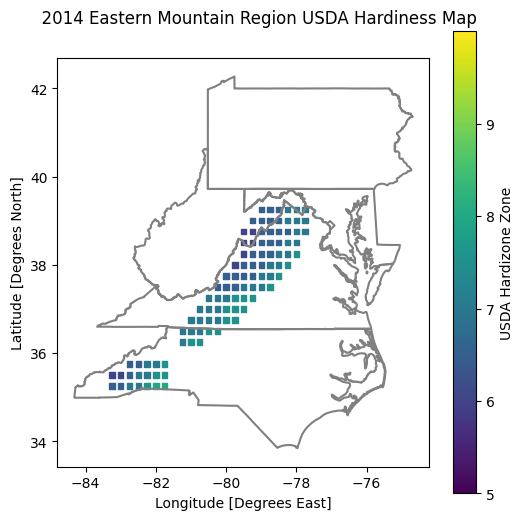

In [124]:
def save_frame(year):
    year_gdf =  gdf.loc[year+'-12-31']
    overlayed = gpd.overlay(east_orchards_gdf, year_gdf, how='intersection',keep_geom_type=False)
    
    us_boundary_map = east.boundary.plot(figsize=(6, 6), color="Gray")
    overlayed.plot(ax = us_boundary_map,column = 'zone', marker = 's',markersize=15, legend = True,
                legend_kwds={"label": "USDA Hardizone Zone", "orientation": "vertical",
                             'ticks':[i for i in range(5,10)]
                            },vmin = 5,vmax = 10)
    
    plt.xlabel('Longitude [Degrees East]')
    plt.ylabel('Latitude [Degrees North]')
    plt.title('      {} Eastern Mountain Region USDA Hardiness Map'.format(year),pad=25)
    # plt.show()
    plt.savefig('../assets/{}_usda.png'.format(year))

save_frame('2014')

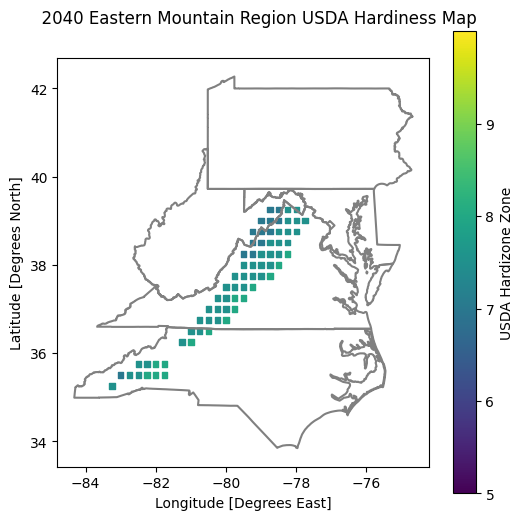

In [125]:
save_frame('2040')